# Predição dos deputados Federais eleitos ou não eleitos


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn import metrics

%config InlineBackend.figure_format = 'png' 
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_orig = pd.read_csv("data/test.csv")

Abaixo é possível análise uma pequena partes dos dados originais.

In [3]:
train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


Vamos agora analisar a distribuição das classes eleito e nçai eleito nos dados de treino

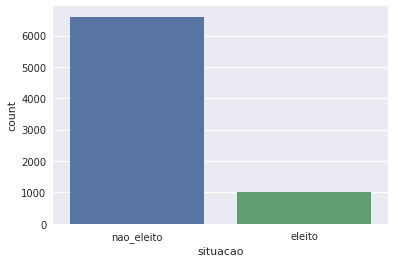

In [4]:
sns.countplot(x="situacao", data=train)

Como podemos verificar na distribuição existem poucas examplares no dados com valor eleito (cerca de 1000) enquanto examplares nos dados com valor não eleito são representados por mais de 6000, o que demostra um desbalanceamento de classes. Este resultado pode resultar e uma alta acurácia de forma erroneamente (Overfitting). 

Nesse contexto, aplicamos a técnica de Random under-sampling para balancear a duas classes. Essa técnica consiste remover amostrar da classe majoritária, ficando assim ambas com mesmo número de aparições e balanceadas. 

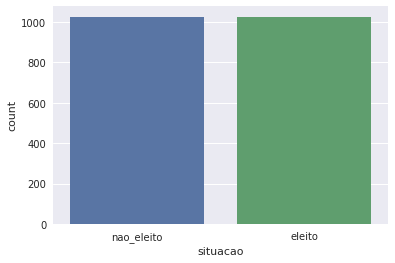

In [5]:
count_class_1, count_class_0 = train.situacao.value_counts()
df_class_0 = train[train['situacao'] == "eleito"]
df_class_1 = train[train['situacao'] == "nao_eleito"]

df_class_1_under = df_class_1.sample(count_class_0, replace=True)
train_balanceado = pd.concat([df_class_1_under, df_class_0], axis=0)

sns.countplot(x="situacao", data=train_balanceado)

### Tratamento nos dados

Para considerar somente features relevantes, foram desconsideradas as seguintes variáveis:

ano - Com os dados de treino e teste utilizados são somente de único ano, esta informação logo pode ser desconsiderada
sequencial_candidato é apenas um identificador de cada candidato que não será útil para predição
Nome - O nome do candidato
Cargo - considerando que todos os parlamentares são Deputados Federais essa infomação não é útil.


In [6]:
train = train.drop(["sequencial_candidato", "nome", "cargo"], axis=1)
test = test.drop(["sequencial_candidato", "nome", "cargo"], axis=1)
train_balanceado = train_balanceado.drop(["sequencial_candidato", "nome", "cargo"], axis=1)

Como medida para reduzir o envisamento nos dados, iremos aplicar log em todas as variáveis numéricas que serão utilizadas na predição. Além disso, iremos remover valores NA dos presentes nos dados.

A função abaixo remove os valores NA das variáveis numéricas e substitui pela média dos valores ao qual a coluna pertence.

In [7]:
def remove_NA(data):
    #remove NA das variáveis e substitui pela média
    return data.fillna(data.mean())

Para aplicar o log nas variáveis, a fim de diminuir seu enviesamento a função abaixo foi criada.

In [8]:
def set_log_numeric_variables(data):
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    
    #coloca valores das variáveis numéricas em escala de log
    data[numeric_feats] = np.log1p(data[numeric_feats])

    return data

Varios dos algoritmos de Aprendizado de máquina para classificação necessitam de dados numéricos. Assim, vamos converter nossas variáveis categóricas em valores numéricos.

In [9]:
def convert_categorical_variable_in_numeric(data):
    le = preprocessing.LabelEncoder()

    data['uf'] = le.fit_transform(data['uf'])
    data['partido'] = le.fit_transform(data['partido'])
    data['sexo'] = le.fit_transform(data['sexo'])
    data['grau'] = le.fit_transform(data['grau'])
    data['estado_civil'] = le.fit_transform(data['estado_civil'])
    data['ocupacao'] = le.fit_transform(data['ocupacao'])
    if ("situacao" in data.columns):
        data['situacao'] = le.fit_transform(data['situacao'])
    
    return data

Para normalizar as variáveis presentes nos dados comm valores entre 0 a 1, a função de normalização abaixo foi criada.

In [10]:
def data_normalization(data):
    #log transform skewed numeric features:
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    
    #identifica as variáveis categóricas
    cat_feats = data.dtypes[data.dtypes == "object"].index

    min_max = preprocessing.MinMaxScaler()
    data_normalized = min_max.fit_transform(data[numeric_feats])
    
    data_normalized = pd.DataFrame(data_normalized, columns=data[numeric_feats].columns)
    
    data = pd.concat([data_normalized, data[cat_feats].reset_index()], axis = 1, sort = False)
    
    return data

Aqui vamos aplicar todas as funções descritas anteriormente.

In [11]:
def data_proccess(data):
    
     #1. substitui NA pela média da coluna
    data = remove_NA(data)
    
    #2. aplica log nas variáveis numéricas
    data = set_log_numeric_variables(data)
    
    #3. normaliza variáveis
    data = data_normalization(data)
    
    #4.Converte variáveis categóricas
    data = convert_categorical_variable_in_numeric(data)
    
    return data

### Modelagem

In [12]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validation(model, cv=10):
    values = []
    f1 = cross_val_score(model, features, label, cv=cv, scoring="f1").mean() 
    precision = cross_val_score(model, features, label, cv=cv, scoring="precision").mean() 
    recall = cross_val_score(model, features, label, cv=cv, scoring="recall").mean() 
    auc = cross_val_score(model, features, label, cv=cv, scoring='roc_auc').mean()
        
    values.append({"f1": f1, "recall": recall, "precision": precision, "roc_auc": auc})
    return(values)

def extrairMelhorValorMetricas(values):
    lista_f1 = []
    lista_recall = []
    lista_precision = []
    lista_auc = []
    
    for v in values:
        lista_f1.append(v[0]['f1'])
        lista_recall.append(v[0]['recall'])
        lista_precision.append(v[0]['precision'])
        lista_auc.append(v[0]['roc_auc'])
        
    return {"all_f1": lista_f1,"index_f1": lista_f1.index(np.max(lista_f1)), 
            "f1": np.max(lista_f1), "recall": np.max(lista_recall), "precision": np.max(lista_precision), 
            "roc_auc": np.max(lista_auc)}    

    

def printMetrics(values):
    return printMetricsNative(values['precision'], values['recall'],  values['f1'], values['roc_auc'])

def printMetricsNative(precision, recall, f1, roc_auc):
    print("As métricas encontradas foram: ")
    print("Recall: ", precision * 100, "%")
    print("Precision: ", recall * 100, "%")
    print("F-score: ", f1 * 100, "%")
    print("AUC: ", roc_auc * 100, "%")


    

In [13]:
#tratamento dados de  treino com classes balanceadas
train_balanceado = data_proccess(train_balanceado)
train_balanceado = train_balanceado.drop("index", axis=1)

#dados utilizados no treino dos modelos
features = train_balanceado.drop('situacao', axis=1)
label = train_balanceado.situacao

#tratamendo dos dados de treino sem balanceamento
train = data_proccess(train)
train = train.drop("index", axis=1)

#Separação dos dados de treino e validação por ano
# dados de 2006
train_data = train[train.ano == 0]
# dados de 2010
validation = train[train.ano == 1]

#Separação dados utilizados como treino
train_X = train_data.drop('situacao', axis=1)
train_Y = train_data.situacao

#Separação dados utilizados como validacao
validacao_X = validation.drop('situacao', axis=1)
validacao_Y = validation.situacao

#dados teste
test = data_proccess(test)
test = test.drop("index", axis=1)

### Regresão Logística

In [14]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='ovr', max_iter=10000)
clf.fit(features, label)

rlg_pred_train_x = clf.predict(train_X)
rlg_pred_validacao_x = clf.predict(validacao_X)

Abaixo é apresentado o desempenho do modelo com os dados separados para treino e teste.

In [15]:
rlg_precision_train = metrics.precision_score(train_Y, rlg_pred_train_x)
rlg_recall_train = metrics.recall_score(train_Y, rlg_pred_train_x)
rlg_auc_roc_train = metrics.roc_auc_score(train_Y, rlg_pred_train_x)
rlg_f1_train = metrics.f1_score(train_Y, rlg_pred_train_x)

print("Resultados predição dados treino")
printMetricsNative(rlg_precision_train, rlg_recall_train, rlg_f1_train, rlg_auc_roc_train)

#Verificando resultados validação
rlg_precision_validacao = metrics.precision_score(validacao_Y, rlg_pred_validacao_x)
rlg_recall_validacao = metrics.recall_score(validacao_Y, rlg_pred_validacao_x)
rlg_auc_roc_validacao = metrics.roc_auc_score(validacao_Y, rlg_pred_validacao_x)
rlg_f1_validacao = metrics.f1_score(validacao_Y, rlg_pred_validacao_x)

print('\n')
print("Resultados predição dados validação")
printMetricsNative(rlg_precision_validacao, rlg_recall_validacao, rlg_f1_validacao, rlg_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.15998472699503 %
Precision:  84.64797913950456 %
F-score:  91.33110603129944 %
AUC:  90.17974005708172 %


Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.23664122137404 %
Precision:  88.43537414965986 %
F-score:  93.5251798561151 %
AUC:  91.87850578828022 %


### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = list(range(1,50))

cv_scores = [cross_validation(KNeighborsClassifier(n_neighbors = k_value), cv=10)
            for k_value in neighbors]

result = extrairMelhorValorMetricas(cv_scores)
optimal_k = neighbors[result['index_f1']]
printMetrics(result)

As métricas encontradas foram: 
Recall:  75.41385294632514 %
Precision:  76.60194174757281 %
F-score:  73.17723327736894 %
AUC:  77.81662479707097 %


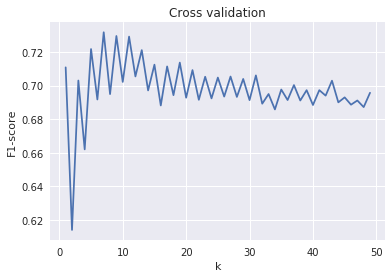

O melhor valor para neighbors é:  7


In [17]:
plot_knn = pd.Series(result['all_f1'], index = neighbors)
plot_knn.plot(title = "Cross validation")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()
print ("O melhor valor para neighbors é: ", optimal_k)

In [18]:
# Treinando modelo 
model = KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(features, label)

x_predict_knn = model.predict(train_X)
x_predict_val_knn = model.predict(validacao_X)

Abaixo é apresentado o desempenho do modelo com os dados separados para treino e teste.

In [19]:
knn_precision_train = metrics.precision_score(train_Y, x_predict_knn)
knn_recall_train = metrics.recall_score(train_Y, x_predict_knn)
knn_auc_roc_train = metrics.roc_auc_score(train_Y, x_predict_knn)
knn_f1_train = metrics.f1_score(train_Y, x_predict_knn)

print("Resultados predição dados treino")
printMetricsNative(knn_precision_train, knn_recall_train, knn_f1_train, knn_auc_roc_train)

#Verificando resultados validação
knn_precision_validacao = metrics.precision_score(validacao_Y, x_predict_val_knn)
knn_recall_validacao = metrics.recall_score(validacao_Y, x_predict_val_knn)
knn_auc_roc_validacao = metrics.roc_auc_score(validacao_Y, x_predict_val_knn)
knn_f1_validacao = metrics.f1_score(validacao_Y, x_predict_val_knn)

print('\n')
print("Resultados predição dados validação")
printMetricsNative(knn_precision_validacao, knn_recall_validacao, knn_f1_validacao, knn_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  88.9248181083266 %
Precision:  71.70795306388527 %
F-score:  79.39372067845542 %
AUC:  59.14832351050015 %


Resultados predição dados validação
As métricas encontradas foram: 
Recall:  89.54314720812184 %
Precision:  75.0 %
F-score:  81.62887552059232 %
AUC:  57.38304093567251 %


### Árvore de decisão (Decision Tree)

In [20]:
from sklearn.tree import DecisionTreeClassifier

depths = list(range(1, 10))

cv_scores_dct = [cross_validation(DecisionTreeClassifier(max_depth = depth_value))
            for depth_value in depths]

result_dct = extrairMelhorValorMetricas(cv_scores_dct)
optimal_depth = depths[result_dct['index_f1']]
printMetrics(result_dct)


As métricas encontradas foram: 
Recall:  95.55238580400103 %
Precision:  88.58652198743575 %
F-score:  90.02310060721103 %
AUC:  94.26683804807053 %


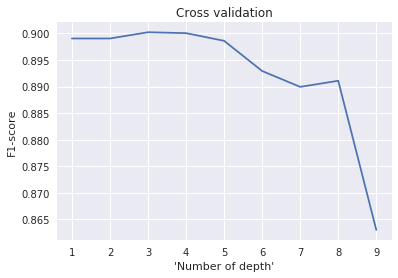

O melhor valor para max depth é:  3


In [21]:
plot_knn = pd.Series(result_dct['all_f1'], index = depths)
plot_knn.plot(title = "Cross validation")
plt.xlabel("'Number of depth'")
plt.ylabel("F1-score")
plt.show()
print ("O melhor valor para max depth é: ", optimal_depth)

In [22]:
#treinando o modelo
classifier = DecisionTreeClassifier(max_depth=optimal_depth)  
classifier.fit(features, label)

x_predict_train_dct = classifier.predict(train_X)
x_predict_val_dct = classifier.predict(validacao_X)

Abaixo é apresentado o desempenho do modelo com os dados separados para treino e teste.

In [23]:
dct_precision_train = metrics.precision_score(train_Y, x_predict_train_dct)
dct_recall_train = metrics.recall_score(train_Y, x_predict_train_dct)
dct_auc_roc_train = metrics.roc_auc_score(train_Y, x_predict_train_dct)
dct_f1_train = metrics.f1_score(train_Y, x_predict_train_dct)

print("Resultados predição dados treino")
printMetricsNative(dct_precision_train, dct_recall_train, dct_f1_train, dct_auc_roc_train)

#Verificando resultados validação
dct_precision_validacao = metrics.precision_score(validacao_Y, x_predict_val_dct)
dct_recall_validacao = metrics.recall_score(validacao_Y, x_predict_val_dct)
dct_auc_roc_validacao = metrics.roc_auc_score(validacao_Y, x_predict_val_dct)
dct_f1_validacao = metrics.f1_score(validacao_Y, x_predict_val_dct)

print('\n')
print("Resultados predição dados validação")
printMetricsNative(dct_precision_validacao, dct_recall_validacao, dct_f1_validacao, dct_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.17582417582418 %
Precision:  82.36636245110822 %
F-score:  89.99287749287748 %
AUC:  89.1363975998231 %


Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.78260869565217 %
Precision:  78.06122448979592 %
F-score:  87.59541984732824 %
AUC:  88.44581692326055 %


### Adaboost

In [24]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

n_estimators_values = list(range(40, 100))

cv_scores_ada = [cross_validation(AdaBoostClassifier(n_estimators=n), cv=5)
            for n in n_estimators_values]

result_ada = extrairMelhorValorMetricas(cv_scores_ada)
optimal_ada = n_estimators_values[result_ada['index_f1']]
printMetrics(result_ada)


As métricas encontradas foram: 
Recall:  91.36482652873286 %
Precision:  89.47241297655695 %
F-score:  90.13605590129933 %
AUC:  95.41496422873757 %


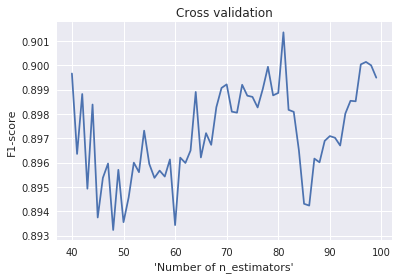

O melhor valor para n_estimators é:  81


In [25]:
plot_knn = pd.Series(result_ada['all_f1'], index = n_estimators_values)
plot_knn.plot(title = "Cross validation")
plt.xlabel("'Number of n_estimators'")
plt.ylabel("F1-score")
plt.show()
print ("O melhor valor para n_estimators é: ", optimal_ada)

In [26]:
#treinando o modelo
abc = AdaBoostClassifier(n_estimators=optimal_ada, learning_rate=1)
abc = abc.fit(features, label)

x_predict_train_abc = abc.predict(train_X)
x_predict_val_abc = abc.predict(validacao_X)

Abaixo é apresentado o desempenho do modelo com os dados separados para treino e teste.

In [27]:
abc_precision_train = metrics.precision_score(train_Y, x_predict_train_abc)
abc_recall_train = metrics.recall_score(train_Y, x_predict_train_abc)
abc_auc_roc_train = metrics.roc_auc_score(train_Y, x_predict_train_abc)
abc_f1_train = metrics.f1_score(train_Y, x_predict_train_abc)

print("Resultados predição dados treino")
printMetricsNative(abc_precision_train, abc_recall_train, abc_f1_train, abc_auc_roc_train)

#Verificando resultados validação
abc_precision_validacao = metrics.precision_score(validacao_Y, x_predict_val_abc)
abc_recall_validacao = metrics.recall_score(validacao_Y, x_predict_val_abc)
abc_auc_roc_validacao = metrics.roc_auc_score(validacao_Y, x_predict_val_abc)
abc_f1_validacao = metrics.f1_score(validacao_Y, x_predict_val_abc)

print('\n')
print("Resultados predição dados validação")
printMetricsNative(abc_precision_validacao, abc_recall_validacao, abc_f1_validacao, abc_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.42462600690449 %
Precision:  84.48500651890483 %
F-score:  91.34801762114537 %
AUC:  90.78051495535885 %


Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.15912031047866 %
Precision:  86.90476190476191 %
F-score:  92.6283987915408 %
AUC:  90.91826789195211 %


### Análise dos valores de Precision, Recall e AUC-Precision&Recall

##### Modelo de Regresão Logísticas

In [28]:
print("Resultados predição dados treino")
printMetricsNative(rlg_precision_train, rlg_recall_train, rlg_f1_train, rlg_auc_roc_train)
print("--------------------------------------------")
print("Resultados predição dados validação")
printMetricsNative(rlg_precision_validacao, rlg_recall_validacao, rlg_f1_validacao, rlg_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.15998472699503 %
Precision:  84.64797913950456 %
F-score:  91.33110603129944 %
AUC:  90.17974005708172 %
--------------------------------------------
Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.23664122137404 %
Precision:  88.43537414965986 %
F-score:  93.5251798561151 %
AUC:  91.87850578828022 %


##### Modelo KNN

In [29]:
print("Resultados predição dados treino")
printMetricsNative(knn_precision_train, knn_recall_train, knn_f1_train, knn_auc_roc_train)
print("--------------------------------------------")
print("Resultados predição dados validação")
printMetricsNative(knn_precision_validacao, knn_recall_validacao, knn_f1_validacao, knn_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  88.9248181083266 %
Precision:  71.70795306388527 %
F-score:  79.39372067845542 %
AUC:  59.14832351050015 %
--------------------------------------------
Resultados predição dados validação
As métricas encontradas foram: 
Recall:  89.54314720812184 %
Precision:  75.0 %
F-score:  81.62887552059232 %
AUC:  57.38304093567251 %


##### Modelo Decision Tree

In [30]:
print("Resultados predição dados treino")
printMetricsNative(dct_precision_train, dct_recall_train, dct_f1_train, dct_auc_roc_train)
print("--------------------------------------------")
print("Resultados predição dados validação")
printMetricsNative(dct_precision_validacao, dct_recall_validacao, dct_f1_validacao, dct_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.17582417582418 %
Precision:  82.36636245110822 %
F-score:  89.99287749287748 %
AUC:  89.1363975998231 %
--------------------------------------------
Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.78260869565217 %
Precision:  78.06122448979592 %
F-score:  87.59541984732824 %
AUC:  88.44581692326055 %


##### Modelo de Adaboosting

In [31]:
print("Resultados predição dados treino")
printMetricsNative(abc_precision_train, abc_recall_train, abc_f1_train, abc_auc_roc_train)
print("--------------------------------------------")
print("Resultados predição dados validação")
printMetricsNative(abc_precision_validacao, abc_recall_validacao, abc_f1_validacao, abc_auc_roc_validacao)

Resultados predição dados treino
As métricas encontradas foram: 
Recall:  99.42462600690449 %
Precision:  84.48500651890483 %
F-score:  91.34801762114537 %
AUC:  90.78051495535885 %
--------------------------------------------
Resultados predição dados validação
As métricas encontradas foram: 
Recall:  99.15912031047866 %
Precision:  86.90476190476191 %
F-score:  92.6283987915408 %
AUC:  90.91826789195211 %


De acordo com os resultados em todos os modelos testados ocorreu um pequena variacao entre os resultados com os dados de teste (dados de 2006) e dados de validação (dados de 2016). As predições com dados de validação foram as que apresentaram melhores resultados.

Comparando f-score (representa uma média entre precision e recall) dos modelos podemos perceber que o modelo de Regressão Logística apresentou melhores resultados entre os modelos variando o f-score entre 94% e 95%. Esses resultados parecerem bons com altos valores de Recall, precision e AUC.

Vamos avaliar agora a importância dos atributos considereados nos modelos.

### Importância das variáveis para os modelos

##### Regressão Logística

Text(0.5,1,'Coefficients Regressão Logística')

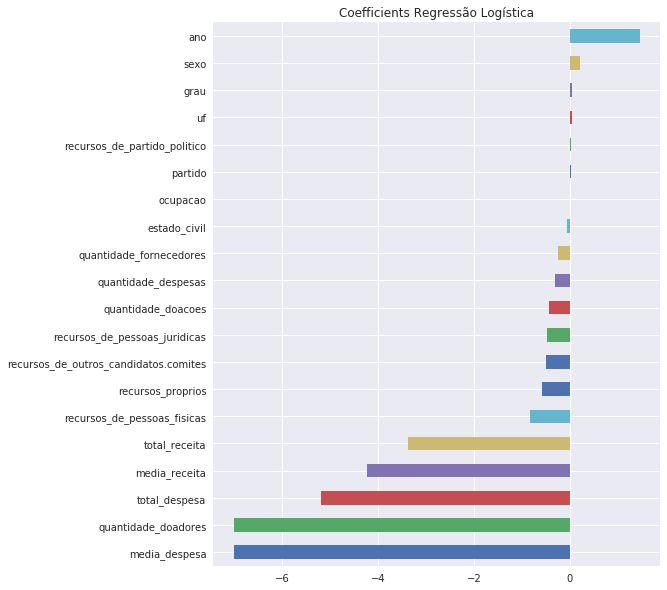

In [32]:
lista_features = list(features.columns.values)

coef = pd.Series(clf.coef_[0], index = lista_features)

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients Regressão Logística")

Partindo da ideia que o modelo de Regressão utilizou da classe "não_eleito" de maneira positiva podemos considerar que as variáveis mais importantes são com coeficientes negativos maiores sendo o total_despesa, media_despesa, quantidade_despesas as com maiores coeficiente e logo as mais importantes para o modelo.

Aparentemente a quantidade de fornecedores, ano, recursos_de_pessoas_juridicas tiveram efeito negativo no modelo. O que pode significar que as variáveis monetárias são mais importantes

##### KNN

Text(0.5,1,'Coefficients KNN baseado no f-score')

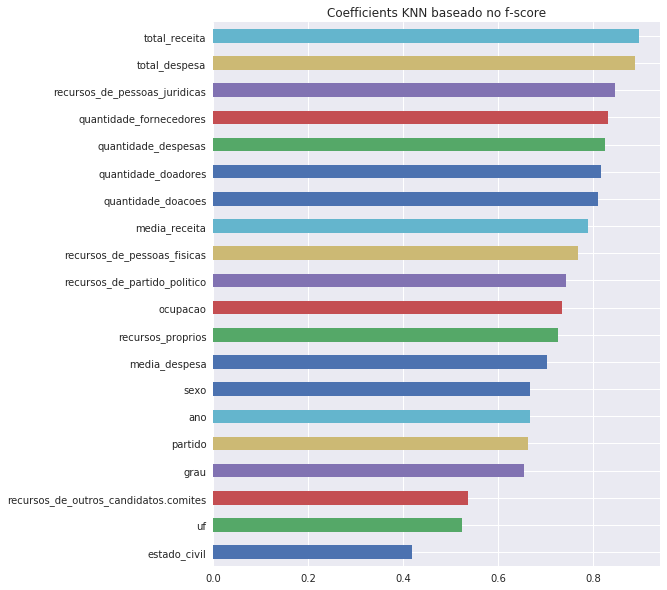

In [33]:
lista_values_conf = []
for i in lista_features:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors = optimal_k), features[[i]], label, scoring="f1", cv=10)
    lista_values_conf.append(scores.mean())
    
coef = pd.Series(lista_values_conf, index = lista_features)

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients KNN baseado no f-score")

Como podemos observar na visualização para o modelo KNN as variáveis total_receita e total_despesa foram consideradas as mais importantes. A variável UF que mostra a unidade federativa do deputado foi a feature menos importante para modelo. Assim como modelo anterior as variáveis monetárias foram consideradas as mais importantes para o modelo.

#### Decision Tree

Text(0.5,1,'Coefficients Decision Tree baseado no f-score')

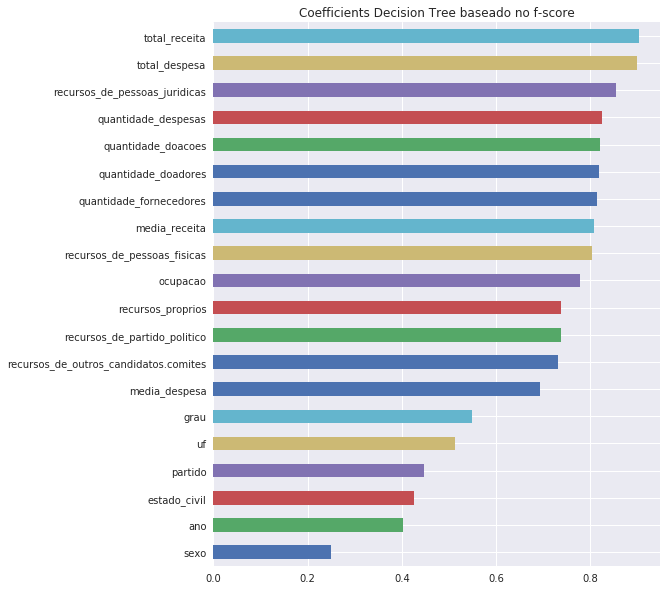

In [34]:
lista_values_conf = []
for i in lista_features:
    scores = cross_val_score(DecisionTreeClassifier(max_depth=optimal_depth), features[[i]], label, scoring="f1", cv=10)
    lista_values_conf.append(scores.mean())
    
coef = pd.Series(lista_values_conf, index = lista_features)

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients Decision Tree baseado no f-score")


Novamente no modelo Decision Tree como no KNN as variáveis consideradas mais importantes foram total_receita e total_depesas. No entanto, a variável considerada menos importante foi sexo.

Podemos observar que novamente as variáveis mais importantes são features numéricas contendo valores monetários

#### Adaboosting

Text(0.5,1,'Coefficients Adaboosting baseado no f-score')

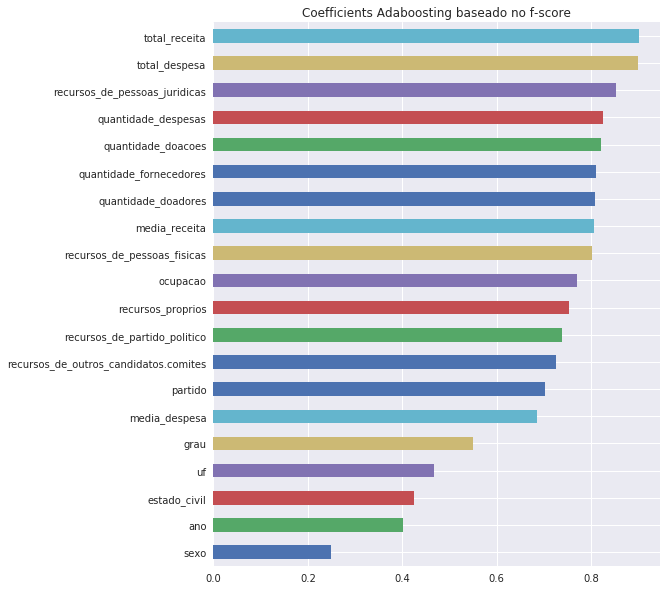

In [35]:
lista_values_conf = []
for i in lista_features:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=optimal_ada, learning_rate=1), features[[i]], label, scoring="f1", cv=10)
    lista_values_conf.append(scores.mean())
    
coef = pd.Series(lista_values_conf, index = lista_features)

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients Adaboosting baseado no f-score")

Com base também na Figura anteior que mostra as variáveis mais importantes para modelo Decision tree, as features mais importantes no modelo adaboosting parecem serem as mesmas.

Vamos agora analisar outros modelos.

### Outros Modelos

#### Random Florest

In [36]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = list(range(1, 100))

cv_scores_rf = [cross_validation(RandomForestClassifier(n_estimators=n))
            for n in n_estimators_list]



In [37]:
result_rf = extrairMelhorValorMetricas(cv_scores_rf)
optimal_n_rf = n_estimators_list[result_rf['index_f1']]
printMetrics(result_rf)

As métricas encontradas foram: 
Recall:  94.8454735143353 %
Precision:  89.1747572815534 %
F-score:  91.68831704650442 %
AUC:  95.61235620021723 %


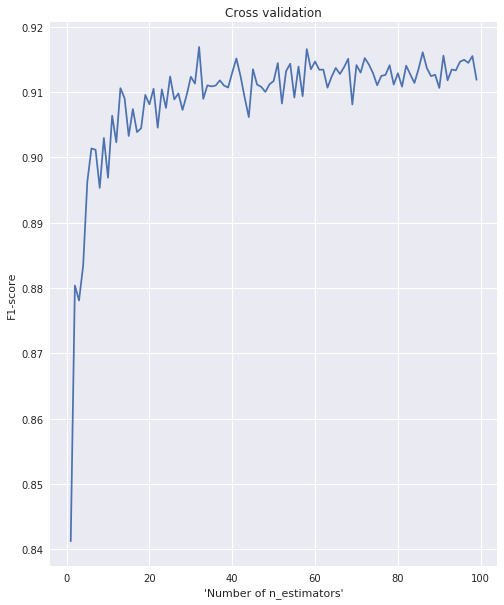

O melhor valor para n_estimators é:  32


In [38]:
plot_knn = pd.Series(result_rf['all_f1'], index = n_estimators_list)
plot_knn.plot(title = "Cross validation")
plt.xlabel("'Number of n_estimators'")
plt.ylabel("F1-score")
plt.show()
print ("O melhor valor para n_estimators é: ", optimal_n_rf)

In [39]:
rf_model = RandomForestClassifier(n_estimators=optimal_n_rf)
rf_model = rf_model.fit(features, label)

x_predict_train_rf = rf_model.predict(train_X)
x_predict_val_rf = rf_model.predict(validacao_X)

#### Grandient Bootisg

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators_list_g = list(range(1, 150))

cv_scores_gd = [cross_validation(GradientBoostingClassifier(n_estimators=n))
            for n in n_estimators_list_g]

In [ ]:
result_gd = extrairMelhorValorMetricas(cv_scores_gd)
optimal_n_gd = n_estimators_list_g[result_gd['index_f1']]
printMetrics(result_gd)

In [ ]:
plot_knn = pd.Series(result_gd['all_f1'], index = n_estimators_list_g)
plot_knn.plot(title = "Cross validation")
plt.xlabel("'Number of n_estimators'")
plt.ylabel("F1-score")
plt.show()
print ("O melhor valor para n_estimators é: ", optimal_n_rf)

In [ ]:
gd_model = GradientBoostingClassifier(n_estimators=optimal_n_gd)
gd_model = gd_model.fit(features, label)

x_predict_train_gd = gd_model.predict(train_X)
x_predict_val_gd = gd_model.predict(validacao_X)

### Submissão 

Vamos agora aplicar os dados de teste com os melhores modelos com base no treino e validação. 

Por fim, vamos criar os csv com os resultados para submissão no Kaggle.

In [ ]:
#aplicando dados de teste a regressão logística
predict_model_rlg = clf.predict(test)

#recuperando id dos candidatos para criação do csv submissão
ids = test_orig.sequencial_candidato

result_rlg_final = pd.DataFrame({"Id": ids, "Predicted": predict_model_rlg})
result_rlg_final.to_csv("data/regressao_logistica_predict.csv", sep=",", encoding="utf-8",
                       index=False, index_label=False)